# Run STARCOP models on raw EMIT data

>  V. Růžička, G. Mateo-Garcia, L. Gómez-Chova, A. Vaughan, L. Guanter, and A. Markham, [Semantic segmentation of methane plumes with hyperspectral machine learning models](https://www.nature.com/articles/s41598-023-44918-6). _Scientific Reports 13, 19999_ (2023). DOI: 10.1038/s41598-023-44918-6.

Demo with loading the AVIRIS trained models to show zero-shot generalisation on the data from EMIT.

In [ ]:
!pip install git+https://github.com/spaceml-org/STARCOP.git
!pip install huggingface_hub[cli,torch]

## Step 1: download EMIT image

In order to download and process the EMIT image we will use the emit reader in the [georeader](https://github.com/spaceml-org/georeader/) package. See [this tutorial](https://github.com/spaceml-org/georeader/blob/main/notebooks/emit_explore.ipynb) for an example of how to load and plot the data.

In [1]:
from huggingface_hub import hf_hub_download
from georeader.readers import emit
from starcop.models import mag1c_emit
from georeader import plot
import starcop
from starcop.models.model_module import ModelModule
import os
import torch
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from starcop.models.utils import padding
import georeader

link = emit.get_radiance_link("EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc")

# Add the user and password of the NASA Earthdata portal (https://search.earthdata.nasa.gov/search)
product = emit.download_product(link,
                                auth=("user","password"))

rst = emit.EMITImage(product)
rst

/home/gonzalo/mambaforge/envs/marsml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc exists. It won't be downloaded again


 
         File: EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (285, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

## Step 2: Load RGB

The RGB bands used to train the model correspond to the wavelengths 640nm, 550nm and 460nm respectively.

In [4]:
wavelengths_read = np.array([640, 550, 460])

bands_read = np.argmin(np.abs(wavelengths_read[:, np.newaxis] - rst.wavelengths), axis=1).tolist()
rst_rgb = rst.read_from_bands(bands_read)
rst_rgb

 
         File: EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (3, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

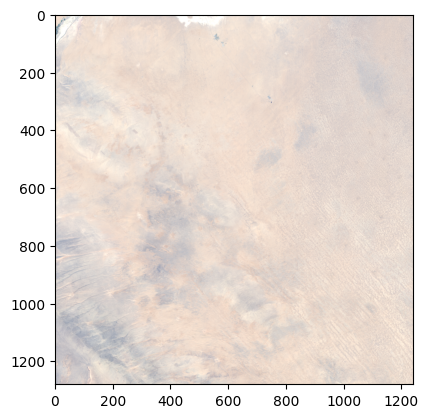

In [5]:
rgb_raw = rst_rgb.load_raw(transpose=True)
plt.imshow((rgb_raw/12).clip(0,1).transpose(1,2,0))

## Step 3: run mag1c on the EMIT product

Run mag1c filter retrieval based on the work of [Foote et al. 2020](https://ieeexplore.ieee.org/document/9034492).

In [6]:
mfoutput, albedo = mag1c_emit.mag1c_emit(rst, column_step=2, georreferenced=False)
mfoutput

	Running mag1c filter by columns: 100%|███████| 621/621 [00:17<00:00, 36.45it/s]


array([[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [382.44855,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
        363.9887 ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)

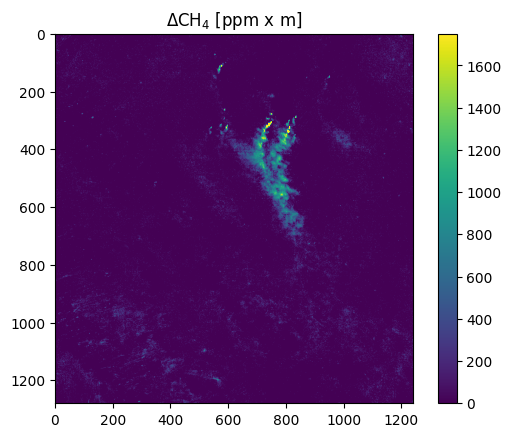

In [7]:
plt.imshow(mfoutput, vmin=0,vmax=1750)
plt.title("$\Delta$CH$_4$ [ppm x m]")
plt.colorbar()

## Step 4: Load STARCOP model

In [8]:
from huggingface_hub import hf_hub_download
# experiment_name = "hyperstarcop_mag1c_only"
experiment_name = "hyperstarcop_mag1c_rgb"
subfolder_local = f"models/{experiment_name}"
config_file = hf_hub_download(repo_id="isp-uv-es/starcop",subfolder=subfolder_local, filename="config.yaml",
                              local_dir=".", local_dir_use_symlinks=False)
model_file = hf_hub_download(repo_id="isp-uv-es/starcop",subfolder=subfolder_local, 
                             filename="final_checkpoint_model.ckpt",
                              local_dir=".", local_dir_use_symlinks=False)

(…)odels/hyperstarcop_mag1c_rgb/config.yaml: 100%|█| 6.89k/6.89k [00:00<00:00, 4
final_checkpoint_model.ckpt: 100%|█████████| 80.0M/80.0M [00:06<00:00, 11.4MB/s]


In [9]:
# TODO upload to hugging face?
hsi_model_path = os.path.join(subfolder_local, "final_checkpoint_model.ckpt")
hsi_config_path =  os.path.join(subfolder_local, "config.yaml")

device = torch.device("cpu")
config_general = omegaconf.OmegaConf.load(os.path.join(os.path.dirname(os.path.abspath(starcop.__file__)), 'config.yaml'))


def load_model_with_emit(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels")

    return model, config

hsi_model, hsi_config = load_model_with_emit(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint models/hyperstarcop_mag1c_rgb/final_checkpoint_model.ckpt`


Loaded model with 4 input channels
successfully loaded HyperSTARCOP model!


## Step 5: re-scale the input data

In [10]:
# Data re-normalisation to fit the range of our models
# (these params were found from statistics of the training datasets and data ranges)

# DIV the EMIT data by
MAGIC_DIV_BY = 240.
RGB_DIV_BY = 20.
# clipping too large values
MAGIC_CLIP_TO = [0.,2.]
RGB_CLIP_TO =   [0.,2.]
# MULT_BY to get it back to the range we saw in the AVIRIS data ...
MAGIC_MULT_BY = 1750.
RGB_MULT_BY =   60.


# NORMALISE
# emit rgb has max ~22
e_mag1c = np.clip(mfoutput / MAGIC_DIV_BY, MAGIC_CLIP_TO[0], MAGIC_CLIP_TO[1]) * MAGIC_MULT_BY
e_rgb = np.clip(rgb_raw / RGB_DIV_BY, RGB_CLIP_TO[0], RGB_CLIP_TO[1]) * RGB_MULT_BY
input_data = np.concatenate([e_mag1c[None], e_rgb], axis=0)
input_data.shape

(4, 1280, 1242)

## Step 6: run inference

In [11]:
pred = padding.padded_predict(input_data, model=lambda x: torch.sigmoid(hsi_model(x)))
pred.shape

(1, 1280, 1242)

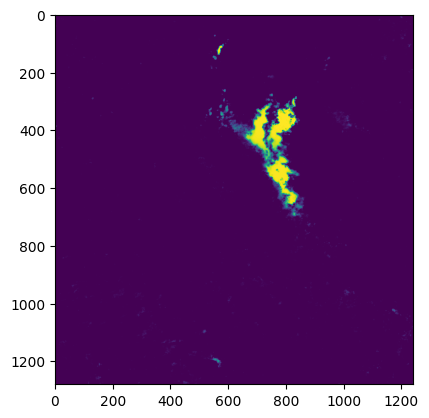

In [12]:
plt.imshow(pred[0],vmin=0,vmax=1)

## Step 7: georreference and plot results

In [13]:
crs_utm = georeader.get_utm_epsg(rst.footprint("EPSG:4326"))
emit_image_utm = rst.to_crs(crs_utm)

In [14]:
mfgeo = emit_image_utm.georreference(mfoutput, fill_value_default=-1)
predgeo = emit_image_utm.georreference(pred[0], fill_value_default=0)
rgbgeo = emit_image_utm.georreference(rgb_raw, fill_value_default=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: title={'center': 'pred'}>

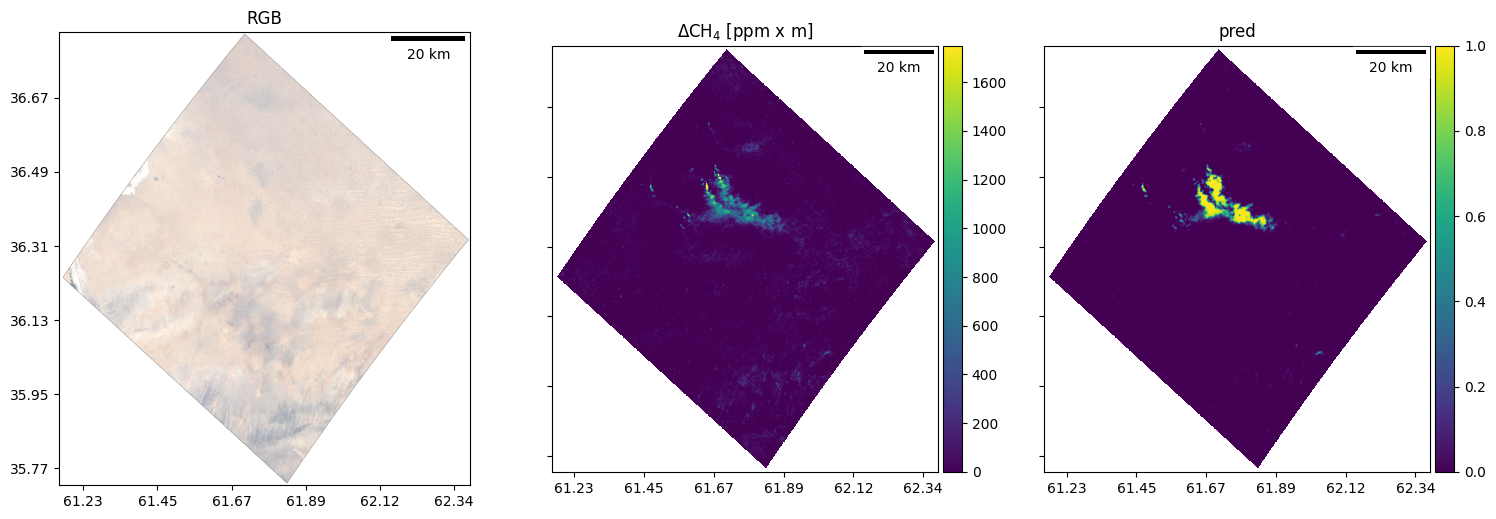

In [15]:
fig, ax = plt.subplots(1,3, figsize=(18,6),sharey=True)

rgbgeomask = np.any(rgbgeo.values == -1, axis=0,keepdims=False)
rgbplot = (rgbgeo/12).clip(0,1)
rgbplot.values[:, rgbgeomask] = -1
plot.show(rgbplot, ax=ax[0], title= "RGB",mask=True, add_scalebar=True)
plot.show(mfgeo, ax=ax[1], title= "$\Delta$CH$_4$ [ppm x m]",mask=True,vmin=0, vmax=1750,
         add_colorbar_next_to=True, add_scalebar=True)
plot.show(predgeo, ax=ax[2], title= "pred", mask=True, vmin=0, vmax=1, add_scalebar=True,
          add_colorbar_next_to=True)

## Licence

The *STARCOP* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

 If you find this work useful please cite:
```
@article{ruzicka_starcop_2023,
	title = {Semantic segmentation of methane plumes with hyperspectral machine learning models},
	volume = {13},
	issn = {2045-2322},
	url = {https://www.nature.com/articles/s41598-023-44918-6},
	doi = {10.1038/s41598-023-44918-6},
	number = {1},
	journal = {Scientific Reports},
	author = {Růžička, Vít and Mateo-Garcia, Gonzalo and Gómez-Chova, Luis and Vaughan, Anna, and Guanter, Luis and Markham, Andrew},
	month = nov,
	year = {2023},
	pages = {19999}
}
```